In [1]:
# libraries
import os
import importlib
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
from numpy.random import seed

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold


from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.combination import maximization
from pyod.utils.utility import standardizer




import keras
from keras import backend as bkend


from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model


os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)


pd.options.display.max_rows = 4000


Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# useful methods
def variance_threshold_selector(data, threshold=0):
    """Eliminate features lower than given variance.

    Parameters
    ----------
    data : `dataframe`
        Dataframe will be processed.

    threshold : `float`
        Threshold value for this operation.

    Returns
    -------
    data : `dataframe`
        Updated dataframe with coloumn names.
    """
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def min_max_scaler(data):
    """Min max scaler for features.

    Parameters
    ----------
    data : `dataframe`
        Dataframe will be processed.

    Returns
    -------
    data : `dataframe`
        Updated dataframe with coloumn names.
    """
    scaled_data = preprocessing.minmax_scale(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

def binning_anomally_score(data, n_bins=6, encode='ordinal', strategy='kmeans'):
    """Bin anomally scores.

    Parameters
    ----------
    data : `array`
        1D numpy array.

    n_bins : `int`
        Number of bins.

    encode : `str`
        Encode style.See: sklearn.

    strategy : `array`
        1D numpy array.

    Returns
    -------
    data : `dataframe`
        Updated dataframe with coloumn names.
    """
    est = preprocessing.KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    res = est.fit_transform(data.reshape(-1,1)).ravel()
    return res

def plt_fig(x, y):
    """Plot figure.

    Parameters
    ----------
    x : `array`
        1D numpy array.

    y : `array`
        1D numpy array.

    Returns
    -------
    No return values given.
    """
    plt.figure(figsize=(10,8))
    axis = sns.barplot(x=x, y=y)
    x=axis.set_xlabel("Cluster Number")
    x=axis.set_ylabel("Number of connections")

### **Given dataset in Kaggle had not been available for foreigners therefore, a near dataset had been selected. The collection of dataset link and description are here [1]. This dataset instance has been selected because it has various anomally event happened in it.**

In [3]:
# read data
df = pd.read_csv("../data/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv", low_memory=False)
# clean coloumn name for whitespace
df = df.rename(columns=lambda x: x.strip())
# create unsupervised dataset by removing labels
df_u = df.drop('Label', axis=1)

In [4]:
# check first few entries of dataset
df_u.head(100)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,0,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,4,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,3,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
3,389,15206,17,12,3452,6660,1313,0,203.058824,425.778474,...,10,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,2,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
5,389,433,11,4,172,326,79,0,15.636364,31.449238,...,4,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
6,88,1088,9,6,3150,3152,1575,0,350.000000,694.509719,...,2,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
7,80,579225,132,150,160,320799,160,0,1.212121,13.926212,...,1,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
8,49666,3,2,0,12,0,6,6,6.000000,0.000000,...,1,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0
9,49413,4,3,0,18,0,6,6,6.000000,0.000000,...,2,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0


In [5]:
# check features and coloumn types
df_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 78 columns):
Destination Port               692703 non-null int64
Flow Duration                  692703 non-null int64
Total Fwd Packets              692703 non-null int64
Total Backward Packets         692703 non-null int64
Total Length of Fwd Packets    692703 non-null int64
Total Length of Bwd Packets    692703 non-null int64
Fwd Packet Length Max          692703 non-null int64
Fwd Packet Length Min          692703 non-null int64
Fwd Packet Length Mean         692703 non-null float64
Fwd Packet Length Std          692703 non-null float64
Bwd Packet Length Max          692703 non-null int64
Bwd Packet Length Min          692703 non-null int64
Bwd Packet Length Mean         692703 non-null float64
Bwd Packet Length Std          692703 non-null float64
Flow Bytes/s                   691695 non-null object
Flow Packets/s                 692703 non-null object
Flow IAT Mean                  

In [6]:
# check statistical parameters of each feature
df_u.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,692703.000000,6.927030e+05,692703.000000,692703.000000,6.927030e+05,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000,...,692703.000000,692703.000000,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,5686.869462,2.800168e+07,9.556261,10.214079,5.550930e+02,1.699644e+04,233.593936,15.022183,60.555440,82.895863,...,6.121279,26.761141,9.224478e+04,4.760852e+04,1.627363e+05,6.315186e+04,2.211122e+07,4.743744e+05,2.252174e+07,2.173373e+07
std,15727.423560,4.276680e+07,747.197814,984.204633,6.163663e+03,2.241175e+06,603.751856,51.068835,157.643794,226.126084,...,715.155068,6.322368,7.007049e+05,4.742081e+05,1.094616e+06,6.051023e+05,3.812415e+07,4.488512e+06,3.848292e+07,3.807725e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,2.010000e+02,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.143700e+04,2.000000,2.000000,8.200000e+01,1.880000e+02,46.000000,0.000000,41.000000,0.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.302437e+07,7.000000,6.000000,3.650000e+02,1.159500e+04,341.000000,32.000000,56.666667,128.916917,...,2.000000,32.000000,9.910000e+02,0.000000e+00,9.910000e+02,9.880000e+02,1.590000e+07,0.000000e+00,1.650000e+07,1.000000e+07
max,65487.000000,1.200000e+08,203943.000000,272353.000000,1.224076e+06,6.270000e+08,24820.000000,2065.000000,4640.757576,6429.190773,...,197124.000000,60.000000,1.000000e+08,7.420000e+07,1.050000e+08,1.000000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [7]:
# we can check number of distinct non-nan values for each features
# some of features may have zero variance
df_u.nunique()

Destination Port                30094
Flow Duration                  363185
Total Fwd Packets                 685
Total Backward Packets            859
Total Length of Fwd Packets      9380
Total Length of Bwd Packets     23483
Fwd Packet Length Max            3728
Fwd Packet Length Min             220
Fwd Packet Length Mean          31471
Fwd Packet Length Std           63498
Bwd Packet Length Max            3836
Bwd Packet Length Min             429
Bwd Packet Length Mean          41095
Bwd Packet Length Std           55643
Flow Bytes/s                   450841
Flow Packets/s                 387031
Flow IAT Mean                  370810
Flow IAT Std                   222370
Flow IAT Max                   148528
Flow IAT Min                    47743
Fwd IAT Total                  100832
Fwd IAT Mean                   162817
Fwd IAT Std                    142925
Fwd IAT Max                     98682
Fwd IAT Min                     37400
Bwd IAT Total                  111743
Bwd IAT Mean

## Feature engineering

In [8]:
# destination port coloumn is nominal categorial feature so we need to encode it using count encoding.
df_u['Destination Port'] = df_u['Destination Port'].map(df_u['Destination Port'].value_counts())

In [9]:
# convert problematic coloumns because of nan values into more easy to handle types
df_u['Flow Bytes/s'] = df_u['Flow Bytes/s'].astype(float)
df_u['Flow Packets/s'] = df_u['Flow Packets/s'].astype(float)

# replace infinite values or bigger than float64 with nan values
df_u = df_u.replace([np.inf, -np.inf], np.nan)

# check how many nan values per coloumn
display(df_u.isna().sum())

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1297
Flow Packets/s                 1297
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

In [10]:
# drop rows includes nan values
# it may handle more effective in other situations however, for this task it is not so important.
df_u = df_u.dropna(axis=0)

In [11]:
# drop all coloumns only has one discint value
df_u = variance_threshold_selector(df_u)
df_u.nunique()

Destination Port                   37
Flow Duration                  363184
Total Fwd Packets                 685
Total Backward Packets            859
Total Length of Fwd Packets      9380
Total Length of Bwd Packets     23483
Fwd Packet Length Max            3728
Fwd Packet Length Min             220
Fwd Packet Length Mean          31471
Fwd Packet Length Std           63498
Bwd Packet Length Max            3836
Bwd Packet Length Min             429
Bwd Packet Length Mean          41095
Bwd Packet Length Std           55643
Flow Bytes/s                   450840
Flow Packets/s                 387030
Flow IAT Mean                  370809
Flow IAT Std                   222370
Flow IAT Max                   148527
Flow IAT Min                    47743
Fwd IAT Total                  100832
Fwd IAT Mean                   162817
Fwd IAT Std                    142925
Fwd IAT Max                     98682
Fwd IAT Min                     37400
Bwd IAT Total                  111743
Bwd IAT Mean

In [12]:
# normalize features of dataframe
# df_unsupervised = pd.DataFrame(m_m_scaler.fit_transform(df_unsupervised.values), 
#                                columns=df_unsupervised.columns)
df_u = min_max_scaler(df_u)
df_u.head(10)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1.000000,3.192417e-04,0.000000,0.000004,0.000005,9.569378e-09,0.000242,0.002906,0.001293,0.000000,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003765,4.000000e-06,0.000049,0.000018,0.000141,5.199362e-07,0.003183,0.000000,0.003369,0.004892,...,0.000020,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003089,9.133333e-06,0.000044,0.000022,0.002573,5.023923e-06,0.063457,0.000000,0.067877,0.098389,...,0.000015,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003765,1.267250e-04,0.000078,0.000044,0.002820,1.062201e-05,0.052901,0.000000,0.043756,0.066226,...,0.000051,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003089,9.108333e-06,0.000039,0.000022,0.002573,5.027113e-06,0.063457,0.000000,0.075419,0.108024,...,0.000010,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.003765,3.616667e-06,0.000049,0.000015,0.000141,5.199362e-07,0.003183,0.000000,0.003369,0.004892,...,0.000020,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.003089,9.075000e-06,0.000039,0.000022,0.002573,5.027113e-06,0.063457,0.000000,0.075419,0.108024,...,0.000010,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.000000,4.826883e-03,0.000642,0.000551,0.000131,5.116411e-04,0.006446,0.000000,0.000261,0.002166,...,0.000005,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000418,3.333333e-08,0.000005,0.000000,0.000010,0.000000e+00,0.000242,0.002906,0.001293,0.000000,...,0.000005,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000017,4.166667e-08,0.000010,0.000000,0.000015,0.000000e+00,0.000242,0.002906,0.001293,0.000000,...,0.000010,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **There are high number of features need to be reduced in order to improve performance of unsupervised algorithms.Different dimension reduction tec. can be used here.I have chosen a basic vanilla autoencoder to compress data by considering performance / ease of implementation (complexity) ratio.**


In [13]:
# split our data test - train fashion
df_u_train, df_u_test = train_test_split(df_u,  train_size = 0.9, 
                                     random_state = seed(2018))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# parameter definition
n_hidden_units = 100
batch_size=100
n_epoch = 30
encoding_dim=  10
dropout = 0.1
n_features = df_u_train.shape[1]

# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                   patience=10)
        
reduce_learn_rate = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      factor=0.1,
                                                      patience=5)
callbacks_list = [early_stop, reduce_learn_rate]


In [15]:
# # model definition
# # *** enceodding part *** 
# # embedding layer
# input_dim = Input(shape=(n_features,))
# encoded = BatchNormalization()(input_dim)
# encoded = Dense(units=n_hidden_units, activation="relu")(encoded)
# encoded = Dropout(rate=dropout)(encoded)

# # hidden layer
# encoded = BatchNormalization()(encoded)
# encoded = Dense(units=n_hidden_units, activation="relu")(encoded)
# encoded = Dropout(rate=dropout)(encoded)

# # hidden layer
# encoded = BatchNormalization()(encoded)
# encoded = Dense(units=n_hidden_units, activation="relu")(encoded)
# encoded = Dropout(rate=dropout)(encoded)

# # hidden layer
# # dropout not applied 
# # https://stackoverflow.com/questions/38125657/what-layers-should-experience-dropout-when-training-a-neural-network
# encoded = BatchNormalization()(encoded)
# encoded = Dense(units=n_hidden_units, activation="relu")(encoded)

# # output layer
# encoded = BatchNormalization()(encoded)
# encoded_last = Dense(units=encoding_dim, activation="relu")(encoded)

# # *** decoding part *** 
# # embedding layer of decoder
# decoded = BatchNormalization()(encoded_last)
# decoded = Dense(units=n_hidden_units, activation="relu")(decoded)
# decoded = Dropout(rate=dropout)(decoded)

# # hidden layer
# decoded = BatchNormalization()(decoded)
# decoded = Dense(units=n_hidden_units, activation="relu")(decoded)
# decoded = Dropout(rate=dropout)(decoded)

# # hidden layer
# decoded = BatchNormalization()(decoded)
# decoded = Dense(units=n_hidden_units, activation="relu")(decoded)
# decoded = Dropout(rate=dropout)(decoded)

# # hidden layer
# # dropout not applied 
# decoded = BatchNormalization()(decoded)
# decoded = Dense(units=n_hidden_units, activation="relu")(decoded)

# # output layer
# decoded = BatchNormalization()(decoded)
# decoded = Dense(units=n_features, activation="relu")(decoded)

# autoencoder = Model(inputs=input_dim, outputs=decoded)
# autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_logarithmic_error', metrics=['accuracy'])





# print(autoencoder.summary())

In [16]:
# second model
input_dim = Input(shape = (n_features, ))

# Encoder Layers
encoded = Dense(n_hidden_units, activation = 'relu')(input_dim)
encoded = Dropout(rate=dropout)(encoded)
encoded = Dense(n_hidden_units, activation = 'relu')(encoded)
encoded = Dropout(rate=dropout)(encoded)
encoded = Dense(n_hidden_units, activation = 'relu')(encoded)
encoded = Dropout(rate=dropout)(encoded)
encoded = Dense(n_hidden_units, activation = 'relu')(encoded)
encoded_last = Dense(encoding_dim, activation = 'relu')(encoded)

# Decoder Layers
decoded = Dense(n_hidden_units, activation = 'relu')(encoded_last)
decoded = Dropout(rate=dropout)(decoded)
decoded = Dense(n_hidden_units, activation = 'relu')(decoded)
decoded = Dropout(rate=dropout)(decoded)
decoded = Dense(n_hidden_units, activation = 'relu')(decoded)
decoded = Dropout(rate=dropout)(decoded)
decoded = Dense(n_hidden_units, activation = 'relu')(decoded)
decoded = Dense(n_features, activation = 'sigmoid')(decoded)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded)

# Compile the Model
# accuracy metric might be redundant for this task because it is unclear of meaning in regression
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_logarithmic_error', metrics=['accuracy'])
# autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 68)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [17]:
# autoencoder will map train data to train data itself
autoencoder.fit(df_u_train, df_u_train,
               validation_split=0.2,
                epochs=n_epoch,
               batch_size=100,
               shuffle=True,
                callbacks=callbacks_list,)

Train on 497812 samples, validate on 124453 samples
Epoch 1/30
497812/497812 [==============================] - 56s 112us/step - loss: 0.0026 - acc: 0.5826 - val_loss: 7.7380e-04 - val_acc: 0.5290
Epoch 2/30
497812/497812 [==============================] - 49s 99us/step - loss: 7.9967e-04 - acc: 0.5907 - val_loss: 5.6769e-04 - val_acc: 0.5684
Epoch 3/30
497812/497812 [==============================] - 49s 98us/step - loss: 5.7207e-04 - acc: 0.5998 - val_loss: 3.5969e-04 - val_acc: 0.5704
Epoch 4/30
497812/497812 [==============================] - 48s 97us/step - loss: 4.5724e-04 - acc: 0.6305 - val_loss: 3.7918e-04 - val_acc: 0.5926
Epoch 5/30
497812/497812 [==============================] - 49s 99us/step - loss: 4.2336e-04 - acc: 0.6460 - val_loss: 3.2751e-04 - val_acc: 0.6753
Epoch 6/30
497812/497812 [==============================] - 49s 98us/step - loss: 4.0289e-04 - acc: 0.6490 - val_loss: 2.9872e-04 - val_acc: 0.6165
Epoch 7/30
497812/497812 [==============================] - 49s

In [18]:
# extract encoder part for feature selection
encoder = Model(inputs = input_dim, outputs = encoded_last)

In [19]:
# use extracted encoder for getting non-linear important features
enc_df_u_train = pd.DataFrame(encoder.predict(df_u_train)).add_prefix('new_feature_')
enc_df_u_test = pd.DataFrame(encoder.predict(df_u_test)).add_prefix('new_feature_')
# drop all features with zero variance
enc_df_u_train = variance_threshold_selector(enc_df_u_train)
enc_df_u_test = variance_threshold_selector(enc_df_u_test)
# normalize data for further tasks
enc_df_u_train = min_max_scaler(enc_df_u_train)
enc_df_u_test = min_max_scaler(enc_df_u_test)

print(enc_df_u_train.shape)
enc_df_u_train.head(20)


(622265, 9)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DataConversionWarning: Data with input dtype float32 were all converted to float64.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DataConversionWarning: Data with input dtype float32 were all converted to float64.


,new_feature_0,new_feature_1,new_feature_2,new_feature_3,new_feature_4,new_feature_6,new_feature_7,new_feature_8,new_feature_9
0,0.074620,0.000000,0.057821,0.025216,0.109718,0.114630,0.000000,0.043232,0.000000
1,0.017899,0.000000,0.004893,0.015778,0.000000,0.001809,0.000000,0.000000,0.027881
2,0.028249,0.000000,0.023833,0.010314,0.043759,0.043716,0.000000,0.020263,0.000000
3,0.010937,0.000000,0.002317,0.010098,0.000000,0.007239,0.000000,0.000000,0.031974
4,0.051154,0.000000,0.000000,0.213145,0.112217,0.142363,0.000000,0.089506,0.000000
5,0.011553,0.095259,0.000000,0.006248,0.015244,0.078543,0.000000,0.019730,0.019944
6,0.000000,0.000000,0.035807,0.079864,0.040893,0.000000,0.087201,0.105571,0.098056
7,0.000000,0.000000,0.082756,0.000000,0.178037,0.081333,0.110735,0.100432,0.320436
8,0.236674,0.000000,0.103577,0.165547,0.271225,0.367272,0.000000,0.203028,0.000000
9,0.018613,0.000000,0.005138,0.016288,0.000000,0.001667,0.000000,0.000000,0.028046


## Anomally detection

### Firstly, we can use a simpler model to cluster data points. Start with K-MEANS:

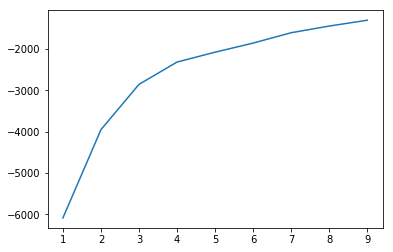

In [20]:
# check # of cluster - loss plot to see which one is suitable
kmean_df = enc_df_u_train.copy()
kmean_test_df = enc_df_u_test.copy()
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(kmean_df) for i in n_cluster]
scores = [kmeans[i].score(kmean_test_df) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

**we can choose a number between 5 - 10 for getting elbow point.For efficiency, I am choosing 6.**

In [21]:
# fitting k-means cluster
num_of_clusters = 6
kmeans = kmeans[num_of_clusters -1]
kmeans.fit(kmean_test_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
# add cluster numbers as coloumn
kmean_test_df['cluster'] = kmeans.labels_
kmean_test_df.head()

,new_feature_0,new_feature_1,new_feature_2,new_feature_3,new_feature_4,new_feature_6,new_feature_7,new_feature_8,new_feature_9,cluster
0,0.010981,0.0,0.000000,0.183854,0.063709,0.034417,0.000000,0.066005,0.000000,5
1,0.000000,0.0,0.082643,0.000000,0.202635,0.085947,0.117280,0.138691,0.317971,4
2,0.010103,0.0,0.002405,0.009523,0.000000,0.007172,0.000000,0.000000,0.029551,0
3,0.693990,0.0,0.702685,0.000000,0.667266,0.665972,0.296333,0.644772,0.242758,2
4,0.693990,0.0,0.702685,0.000000,0.667266,0.665972,0.296333,0.644772,0.242758,2


0    35847
5    20196
1     4273
3     3916
4     3911
2      998
Name: cluster, dtype: int64

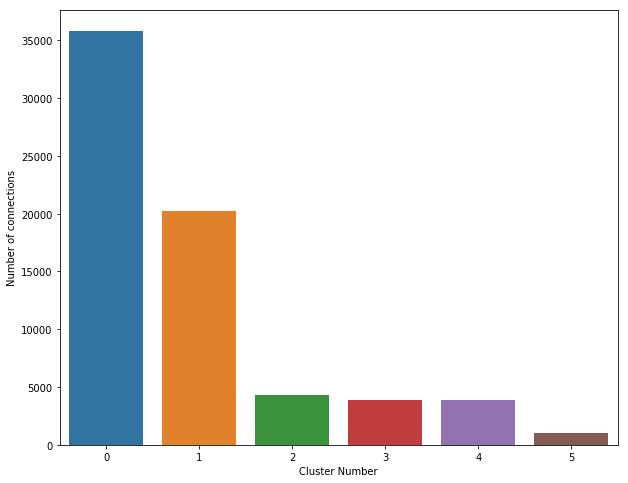

In [23]:
# check number of samples in each clusters by plotting
cluster_num_arr = np.arange(0,num_of_clusters,1)
freq_of_cluster = kmean_test_df['cluster'].value_counts()
plt_fig(cluster_num_arr, freq_of_cluster)
display(kmean_test_df['cluster'].value_counts())

BENIGN              43967
DoS Hulk            23028
DoS GoldenEye         976
DoS Slowhttptest      584
DoS slowloris         584
Heartbleed              2
Name: Label, dtype: int64

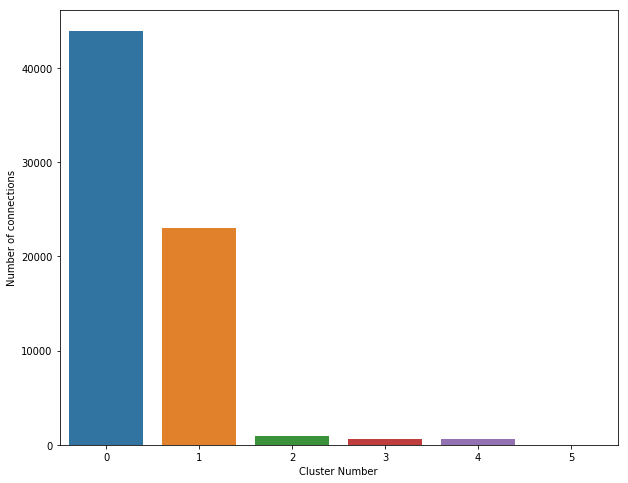

In [24]:
# check ground truth
# select test rows from labelled data
ground_truth = df[df.index.isin(df_u_test.index)]
# get counts of each label
label_counts = ground_truth['Label'].value_counts()
# plot figure
plt_fig(np.arange(0,len(label_counts),1), label_counts)
display(label_counts)

### Lets check another method for clustering connections, Isolation forests[2]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


array([ 1187,  2408,  4834,  9760, 12549, 38403])

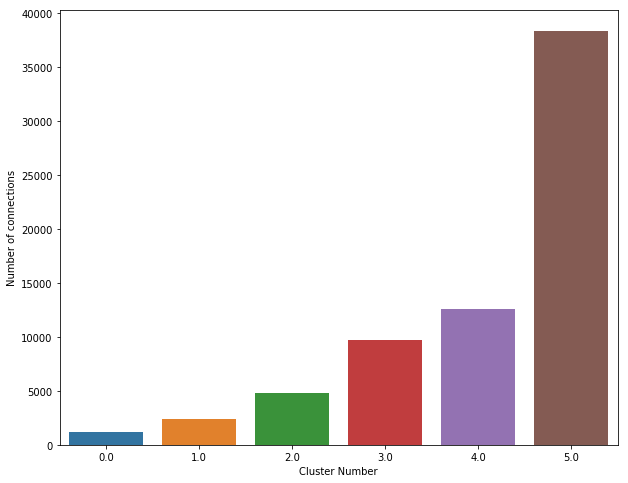

In [25]:
iso_df = enc_df_u_train.copy()
iso_test_df = enc_df_u_test.copy()
contamination = 0.3  # the proportion of outliers in the data set

# training the model
clf = IsolationForest(contamination=contamination)
clf.fit(iso_df)
# get scores
res = clf.decision_function(iso_test_df)

# bin the scores using discretizer
res = binning_anomally_score(res)
# get unique elements and their frequency
unique_elements, counts_elements = np.unique(res, return_counts=True)
# plot frequencies
plt_fig(unique_elements, counts_elements)
display(counts_elements)

### **According to paper[3], we can use different approach to achieve better accuracy.In the paper, kdd99 task is very similar to our task so we can take several better methods and apply our problem. 2 of them have been selected.**

### Thirdly, we can use Clustering-Based Local Outlier Factor(CBLOF)[4]:

In [26]:
cblof_df = enc_df_u_train.copy()
minimum_n_cluster = 2
max_n_cluster = 9
n_cluster = max_n_cluster - minimum_n_cluster
contamination = 0.3  # the proportion of outliers in the data set
# initilize models with different parameters
test_scores = np.zeros([enc_df_u_test.shape[0], n_cluster])
# combine cblof with different cluster number and save anomally score of each sample points for test
for k in range(minimum_n_cluster, max_n_cluster):
    try:
        clf = CBLOF(n_clusters=k , contamination=contamination)
    except:
        pass
    else:
        clf.fit(cblof_df)
        test_scores[:, k-2] = clf.decision_function(enc_df_u_test)

# normalize the scores for evaluation
test_scores_norm = standardizer(test_scores)
# ensemble anomally score recoreded by different classifier
comb_by_maximization = maximization(test_scores_norm)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

array([53205, 12106,  2591,  1145,    90,     4])

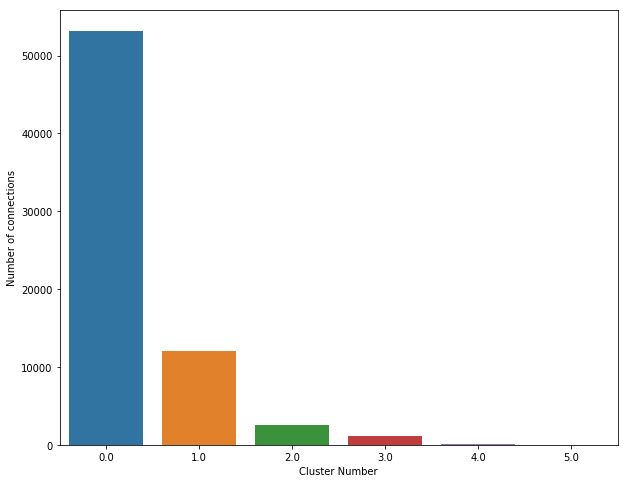

In [27]:
# bin the scores using discretizer
res = binning_anomally_score(comb_by_maximization)
# get unique elements and their frequency
unique_elements, counts_elements = np.unique(res, return_counts=True)
# plot frequencies
plt_fig(unique_elements, counts_elements)
display(counts_elements)

### Lastly, we can use Histogram-based anomaly detection algorithm (HBOS)[5]:

In [28]:
hbos_df = enc_df_u_train.copy()
minimum_n_cluster = 2
max_n_cluster = 9
n_cluster = max_n_cluster - minimum_n_cluster
contamination = 0.3  # the proportion of outliers in the data set
# initilize models with different parameters
test_scores = np.zeros([enc_df_u_test.shape[0], n_cluster])
# combine cblof with different cluster number and save anomally score of each sample points for test
for k in range(minimum_n_cluster, max_n_cluster):
    try:
        clf = HBOS(n_bins=k , contamination=contamination)
    except:
        pass
    else:
        clf.fit(cblof_df)
        test_scores[:, k-2] = clf.decision_function(enc_df_u_test)

# normalize the scores for evaluation
test_scores_norm = standardizer(test_scores)
# ensemble anomally score recoreded by different classifier
comb_by_maximization = maximization(test_scores_norm)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

array([56271,  9896,  1728,   286,    30,   930])

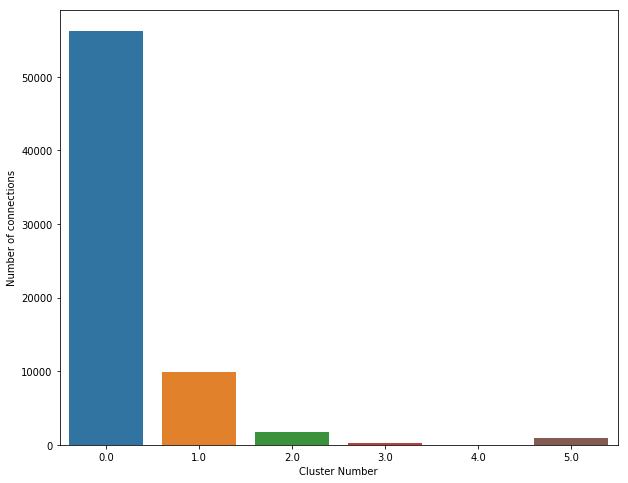

In [29]:
# bin the scores using discretizer
res = binning_anomally_score(comb_by_maximization)
# get unique elements and their frequency
unique_elements, counts_elements = np.unique(res, return_counts=True)
# plot frequencies
plt_fig(unique_elements, counts_elements)
display(counts_elements)

# Definition of normal

### In this chapter, we will try to specify the characteristics of a normal connection.To do that, lets compare two clusters to get a definition of a normal connection. The intuitive way is selecetion of most frequent cluster (probably represents normal connections) and least frequent one (probably includes harsh attacts).However,  the dimensionality of data is high so that I will choose few features to describe clusters.

In [39]:
analysis_test_df = ground_truth.copy().drop('Label', axis=1)
analysis_test_df = analysis_test_df.reset_index(drop=True)
analysis_test_df['cluster'] = kmeans.labels_
display(analysis_test_df['cluster'].value_counts())

0    35847
5    20196
1     4273
3     3916
4     3911
2      998
Name: cluster, dtype: int64

In [41]:
# filter most frequent class
freq_df = analysis_test_df.loc[analysis_test_df['cluster'] == 0]
# filter least freq class
l_freq_df = analysis_test_df.loc[analysis_test_df['cluster'] == 2]

In [42]:
# describe most frequent class
freq_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,cluster
count,35847.000000,3.584700e+04,35847.000000,35847.000000,3.584700e+04,3.584700e+04,35847.000000,35847.000000,35847.000000,35847.000000,...,35847.000000,3.584700e+04,3.584700e+04,3.584700e+04,3.584700e+04,3.584700e+04,3.584700e+04,3.584700e+04,3.584700e+04,35847.0
mean,5662.151254,2.784942e+07,11.590844,13.088989,5.708395e+02,2.291109e+04,233.795046,15.336039,60.995744,82.563340,...,26.745669,9.252759e+04,4.857966e+04,1.625674e+05,6.271238e+04,2.205527e+07,4.742317e+05,2.246635e+07,2.167681e+07,0.0
std,15702.256753,4.262044e+07,1054.294360,1419.023918,7.229634e+03,3.090490e+06,590.520348,53.970772,157.983077,220.350627,...,6.312299,7.639654e+05,5.214028e+05,1.129392e+06,6.658754e+05,3.806145e+07,4.477341e+06,3.842144e+07,3.801362e+07,0.0
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,53.000000,2.020000e+02,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,80.000000,6.157800e+04,2.000000,2.000000,8.200000e+01,1.880000e+02,46.000000,0.000000,41.000000,0.000000,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,443.000000,8.265513e+07,7.000000,6.000000,3.650000e+02,1.159500e+04,340.000000,33.000000,56.833333,129.081534,...,32.000000,9.900000e+02,0.000000e+00,9.900000e+02,9.870000e+02,1.490000e+07,0.000000e+00,1.600000e+07,1.000000e+07,0.0
max,65178.000000,1.200000e+08,199565.000000,268604.000000,1.177247e+06,5.850000e+08,10136.000000,2065.000000,2319.000000,4415.268169,...,60.000000,6.800000e+07,6.370000e+07,9.010000e+07,6.800000e+07,1.200000e+08,6.640000e+07,1.200000e+08,1.200000e+08,0.0


In [43]:
# describe most frequent class
l_freq_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,cluster
count,998.000000,9.980000e+02,998.000000,998.000000,998.000000,9.980000e+02,998.000000,998.000000,998.000000,998.000000,...,998.000000,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,998.0
mean,5412.549098,2.773812e+07,24.383768,32.193387,1331.093186,6.025284e+04,261.461924,16.018036,68.934555,92.270486,...,26.809619,6.753816e+04,3.857954e+04,1.190220e+05,4.476683e+04,2.243235e+07,6.330503e+05,2.295584e+07,2.195470e+07,2.0
std,15288.627272,4.246912e+07,599.447250,865.250275,23315.388795,1.756732e+06,881.338984,66.275690,211.253110,283.979891,...,6.281417,4.592516e+05,3.379910e+05,6.840979e+05,3.988786e+05,3.829756e+07,5.688510e+06,3.885836e+07,3.820719e+07,0.0
min,22.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
25%,53.000000,2.070000e+02,2.000000,1.000000,12.000000,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
50%,80.000000,6.668350e+04,2.000000,2.000000,84.000000,2.060000e+02,46.000000,0.000000,42.000000,0.000000,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
75%,443.000000,8.068676e+07,7.000000,6.000000,366.750000,1.159500e+04,343.000000,33.000000,58.458333,131.819578,...,32.000000,9.870000e+02,0.000000e+00,9.870000e+02,9.867500e+02,1.930000e+07,0.000000e+00,3.122500e+07,1.017500e+07,2.0
max,61157.000000,1.199775e+08,18940.000000,27336.000000,719406.000000,5.550000e+07,18980.000000,1983.000000,3786.347368,5185.441640,...,44.000000,7.010752e+06,5.243429e+06,7.415813e+06,7.010752e+06,1.160000e+08,6.640000e+07,1.160000e+08,1.160000e+08,2.0


In [46]:
# we can check port of connections
display(freq_df['Destination Port'].value_counts()[:15])
display(l_freq_df['Destination Port'].value_counts()[:15])

80      15534
53      10177
443      5226
123       236
22        109
137        75
21         65
389        57
88         44
139        29
465        26
3268       25
138        19
0          15
445        10
Name: Destination Port, dtype: int64

80       422
53       288
443      155
123        6
22         3
137        3
465        2
88         2
38276      1
53638      1
55686      1
389        1
45403      1
41318      1
55649      1
Name: Destination Port, dtype: int64

### Most frequent ports seems identical so there is no sign of vulnability related to port number. However, in the abnormal class, higher ports is in top 15 port numbers while it is not the situation in 

# References

[1] https://www.unb.ca/cic/datasets/ids-2017.html <br>
[2] https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf <br>
[3] https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0152173&type=printable <br>
[4] He, Z., Xu, X. and Deng, S., 2003. Discovering cluster-based local outliers. Pattern Recognition Letters, 24(9-10), pp.1641-1650.  <br>
[5] https://pdfs.semanticscholar.org/5cf8/81d1db19834f123fcfc79ad32097aeafe17f.pdf